In [1]:
import numpy as np
from scipy.io import loadmat

In [2]:
def load_normalized_mat(mat_path):
    
    mat = loadmat(mat_path)
    gaze_vec = mat['data'][0][0][0][0][0][0]
    eye_img = mat['data'][0][0][0][0][0][1]
    
    return eye_img, gaze_vec

In [3]:
mat_path_train = '../data/MPIIGaze/Data/Normalized/p00/day01.mat'
mat_path_val = '../data/MPIIGaze/Data/Normalized/p00/day02.mat'

eye_img_tr, gaze_vec_tr = load_normalized_mat(mat_path_train)
eye_img_val, gaze_vec_val = load_normalized_mat(mat_path_val)

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

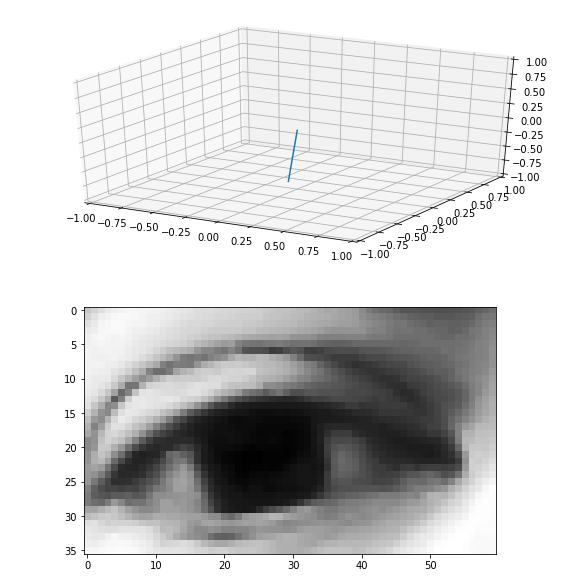

In [6]:
gid = 0

zero = np.zeros([1, 3])
gaze = gaze_vec_tr[gid, :]

gaze_dir = np.vstack([zero, gaze])

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, projection='3d')

ax.plot(gaze_dir[:,0] , gaze_dir[:, 1], gaze_dir[:, 2])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax2 = fig.add_subplot(212)

ax2.imshow(eye_img_tr[gid], cmap='gray')

In [8]:
from utils.angles import rad2bit, bit2deg

phi_gt = np.arctan(gaze_vec_tr[:, 1] / gaze_vec_tr[:, 0])
theta_gt = np.arccos(gaze_vec_tr[:, 2])

phi_gt_bit = rad2bit(phi_gt)
theta_gt_bit = rad2bit(theta_gt)

In [13]:
gaze_vec_tr[0]

array([-0.12202543,  0.09011014, -0.98842802])

In [65]:
import math as m

def cart2sph(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    elev = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(y,x)                           # phi
    return r, elev, az

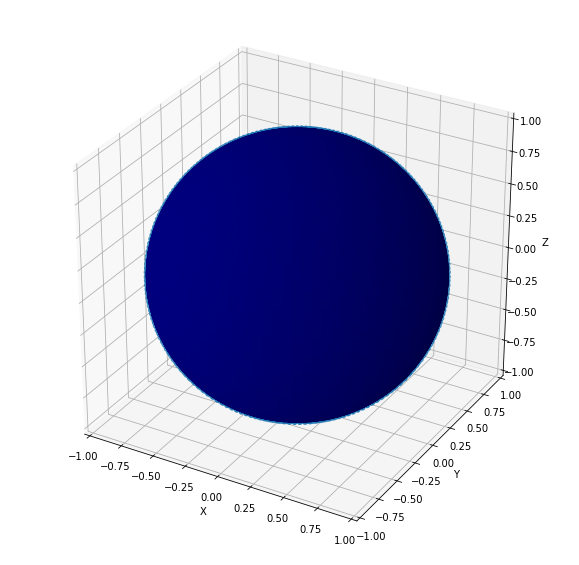

In [87]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import special
from scipy.stats import vonmises, norm

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
mesh_size = 100j
phi, theta = np.mgrid[0:2*pi:mesh_size, 0:pi:mesh_size/2]

x = r * sin(theta) * cos(phi)
y = r * sin(theta) * sin(phi)
z = r * cos(theta)

phi_vals = np.mgrid[0:2*pi:mesh_size]
theta_vals = np.mgrid[0:pi:mesh_size/2]

_, theta_gt, phi_gt = cart2sph(gaze_vec_tr[0,0], gaze_vec_tr[0,1], gaze_vec_tr[0,2])
phi_pdf = vonmises.pdf(phi_vals, loc=pi, kappa=1.0).reshape([1, -1])
theta_pdf = vonmises.pdf(theta_vals, loc=pi/4, kappa=1.0).reshape([1, -1])

#norm = colors.Normalize()

colorfunction = np.zeros([100, 50]) #phi_pdf.T.dot(theta_pdf)

norm=colors.Normalize(vmin = np.min(colorfunction), vmax = np.max(colorfunction), clip = False)

#print(colorfunction)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.jet(norm(colorfunction)))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [88]:
colorfunction.shape

(100, 50)

In [78]:
z.shape

(50, 25)

In [72]:
sin(theta_gt) * cos(phi_gt)

0.090110139961111793

In [73]:
sin(theta_gt) * sin(phi_gt)

-0.58716479455445592

In [55]:
theta_gt[0]

2.9893141987385534

In [74]:
gaze_vec_tr[0]

array([-0.12202543,  0.09011014, -0.98842802])

In [51]:
colorfunction.shape

(50, 25)

In [36]:
vggbit_cosine_model.model.predict(gaze_img[0:10])

array([[ 0.74975163, -0.66171938],
       [ 0.54238766, -0.8401283 ],
       [ 0.6194604 , -0.78502774],
       [ 0.59362859,  0.80473906],
       [ 0.30595237,  0.95204675],
       [ 0.54878092, -0.83596617],
       [ 0.7903946 , -0.61259806],
       [ 0.41240904,  0.91099882],
       [ 0.74981004, -0.6616531 ],
       [ 0.80102843, -0.59862632]], dtype=float32)

In [9]:
from models import vgg

image_height, image_width  = gaze_img.shape[1:3]

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=1,
                                predict_kappa=False,
                                loss_type='cosine')

gaze_img = np.expand_dims(gaze_img, axis=-1)

vggbit_cosine_model.fit(train_data=[gaze_img, phi_gt_bit], val_data=[gaze_img, phi_gt_bit], n_epochs=10, batch_size=32)

Using TensorFlow backend.
